# Simulate Battery for Solar Plant

## Introduction

Notebook to simulate batteries of different sizes for an existing solar plant. 

On sunny days your PV system usually feeds the excess energy that you cannot use at home to the grid, while you have to draw energy from the grid on cloudy days (and at night). Your own consumption can be increased by adding a battery to your PV system. The size of the battery (and inverter) heavily depends on the setup of you PV system and epecially on your personal power consumption profile.

Modern energy meters provide all the information needed to simulate different batteries and inverters for your personal needs. This software uses this data to find out which combination best fits your needs and assists you in your buying decision. The script simulates batteries of different sizes which are charged, when power is fed to the grid and discharged, when power is drawn from the grid.

The original project https://github.com/PV-Soft/Battery-Simulation used an unspecified json export from openHab.

This modification uses the CSV-Export of discovergy.com smartmeter, with 15minute time periods, but time periods are flexible.
There is a little glitch with daylight saving time switches, but with 3kWh in my case, this has no impact.
The input data has to be in some format, containing a timestamp and the power, where incoming energy from the grid is positive and outgoing export is negative.

If some values are irritating high or low, please check the format of the timestamp in your raw data.

If runtime is too long, reduze the amount of batteries to simulate in battery_sizes and battery_names.

1, 2 or 3 phase can be switched by max_phase_load. This is only relevant for charging capacity (assuming equal distribution of power from solar inverter), at least in Germany, as the meters sum up energy from all phases.

## Settings

In [79]:
# Maximum charging and discharging power of battery / inverter combination in W
max_discharging_power = 4500
max_charging_power = 4500
max_phase_load = 3
#max_phase_load = 1
efficiency = 0.95

# Set sizes (in kWh) and names of batteries of to be simulated
#battery_sizes = [1,5,10,15,20,30,40,50]
#battery_names = ["1","5","10","15", "20", "30","40", "50"]
battery_sizes = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
battery_names = ["1","2","3","4","5","6","7","8","9","10","11","12","13","14","15"]
#battery_sizes = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,40,50]
#battery_names = ["1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19", "20", "30","40", "50"]

#Date Time Format String for pandas.read_csv() function
dateTimeFormatString = '%d.%m.%Y %H:%M' #German Time Format String, needed for Discovergy .csv

## Import Data

In [80]:
%matplotlib inline
import argparse
import pandas as pd
from influxdb import DataFrameClient
from datetime import datetime

import matplotlib.pyplot as plt
import datetime
import numpy as np
import json

Original load from openHab json

In [81]:

#with open('resultJanMrz.json') as json_file:
#    raw_dataJanMrz = json.load(json_file)

#with open('resultAprilMai.json') as json_file:
#    raw_dataApril= json.load(json_file) 

# #JanMrz = raw_dataJanMrz['results'][0]['series'][0]['values']
#AprilMai = raw_dataApril['results'][0]['series'][0]['values']

#JanMrz.extend(AprilMai)

#all_data = JanMrz

#df = pd.DataFrame.from_records(all_data, columns = ['timestamp', 'power'])   


Load from Discovergy .csv

In [82]:
#data = pd.read_csv(r'DT.csv', encoding='latin-1')
data = pd.concat(map(lambda file: pd.read_csv(file, encoding='latin-1'), [r'2020_2R.csv', r'2021_2R.csv',r'2022_2R.csv']))

df = pd.DataFrame.from_records(data, columns = ['Zeit', 'Zählerstand Bezug (Wh)','Leistung Bezug (W)', 'Leistung Einspeisung (W)'])
df['Leistung Einspeisung (W)'] = df['Leistung Einspeisung (W)'] * max_phase_load / 3
df['timestamp'] = df['Zeit']
#df['power'] = df['Leistung Einspeisung (W)'] - df['Leistung Bezug (W)']
df['power'] = df['Leistung Bezug (W)'] - df['Leistung Einspeisung (W)']
#df.tail()

## Calculate Power and Energy usable by Battery

In [83]:
#df = pd.DataFrame.from_records(all_data, columns = ['timestamp', 'power'])

# calculate column power_battery. 
# power in this column is limited by max_discharging_power and max_charging_power of the inverter
df['power_battery'] = df['power']
df.loc[df['power'] > max_discharging_power, 'power_battery'] = max_discharging_power
df.loc[df['power'] < -max_charging_power, 'power_battery'] = -max_charging_power

# calculate excess power, not usable by battery due to above limitation of min/max (dis)charging power.
# This fraction is always fed or drawn to/from the grid
df['power_excess'] = df['power'] - df['power_battery']

# Calculate time difference to previous row
#assert German time format
df['time'] = pd.to_datetime(df['timestamp'], format=dateTimeFormatString)
df['time_period'] = df['time'].diff()
df['time_period'] = df['time_period'] /np.timedelta64(1,'s')

# For comparisson, calculate total energy used from grid without any battery
# Has to match green line in plot below
df['energy'] = - df['time_period'] * df['power'] / (60 * 60 * 1000)
summe = df.loc[df.energy < 0, 'energy' ].sum()

# Calculate Energy usable by battery for charging / discharging in kWh
df['energy_battery'] = - df['time_period'] * df['power_battery']*efficiency / (60 * 60 * 1000)
df['energy_battery'] = df['energy_battery'].fillna(0)
df.head()

# Calculate excess energy that was not considered during charge / discharge of the batteries
# because it the total power was above / below the maximum charge / discharge power
df['energy_inverter_excess'] = - df['time_period'] * df['power_excess'] / (60 * 60 * 1000)
df['energy_inverter_excess'] = df['energy_inverter_excess'].fillna(0)
df.tail()

,Zeit,Zählerstand Bezug (Wh),Leistung Bezug (W),Leistung Einspeisung (W),timestamp,power,power_battery,power_excess,time,time_period,energy,energy_battery,energy_inverter_excess
85710,19.09.2022 10:00,7577151,0,2149.0,19.09.2022 10:00,-2149.0,-2149.0,0.0,2022-09-19 10:00:00,900.0,0.53725,0.510387,-0.00000
85711,19.09.2022 10:15,7577151,0,1635.0,19.09.2022 10:15,-1635.0,-1635.0,0.0,2022-09-19 10:15:00,900.0,0.40875,0.388313,-0.00000
85712,19.09.2022 10:30,7577151,0,2822.0,19.09.2022 10:30,-2822.0,-2822.0,0.0,2022-09-19 10:30:00,900.0,0.70550,0.670225,-0.00000
85713,19.09.2022 10:45,7577151,0,5799.0,19.09.2022 10:45,-5799.0,-4500.0,-1299.0,2022-09-19 10:45:00,900.0,1.44975,1.068750,0.32475
85714,19.09.2022 11:00,7577151,0,5045.0,19.09.2022 11:00,-5045.0,-4500.0,-545.0,2022-09-19 11:00:00,900.0,1.26125,1.068750,0.13625


## Define Function to Simulate Battery

In [84]:
# Function to simulate a battery of size battery_size. 
# df contains energy that could be charged or discharged at each time.
def simulate_battery(df, battery_size):
    print('Simulating battery of size ', str(battery_size), ' kWh.')
    last_energy_in_battery = 0 
    last_total_energy_provided_by_battery = 0 

    energy_in_battery = []
    energy_excess_to_grid = []
    energy_provided_by_battery = []
    total_energy_provided_by_battery = []

    # go through all rows and check if energy can be charged or discharged to battery
    for row in df.iterrows():
        # Add energy of this row to battery and check if battery is either full or empty. 
        # In this case, set battery state to battery_size or zero. 
        # Copy excess energy, not taken by battery to this_energy_excess_to_grid
        this_energy_in_battery =  row[1]['energy_battery'] + last_energy_in_battery 
        # If battery is full, copy excess to this_energy_excess_to_grid
        if this_energy_in_battery > battery_size:
            this_energy_excess_to_grid = this_energy_in_battery - battery_size
            this_energy_in_battery = battery_size
        # If battery is empty, copy excess to this_energy_excess_to_grid
        elif this_energy_in_battery < 0:
            this_energy_excess_to_grid = this_energy_in_battery
            this_energy_in_battery = 0
        # If battery is not full or empty, set this_energy_excess_to_grid to zero
        else:
            this_energy_excess_to_grid = 0
        
        # Append data to lists
        energy_in_battery.append( this_energy_in_battery )
        energy_excess_to_grid.append(this_energy_excess_to_grid)
            
            
        # Check if the battery was discharged in this row.
        # If this is the case, copy energy of this row to new column. 
        # And calculate the total of the energy discharged from the battery. 
        # This value is used to see how much energy was used from the battery
        
        if this_energy_in_battery < last_energy_in_battery:
            energy_provided_by_battery.append(last_energy_in_battery - this_energy_in_battery)
            last_total_energy_provided_by_battery = last_total_energy_provided_by_battery + last_energy_in_battery - this_energy_in_battery
            total_energy_provided_by_battery.append(last_total_energy_provided_by_battery)
        # If battery was charged, do not add energy to list
        else:
            energy_provided_by_battery.append(0)
            total_energy_provided_by_battery.append(last_total_energy_provided_by_battery)

        last_energy_in_battery = this_energy_in_battery
        
    return energy_in_battery, energy_excess_to_grid, energy_provided_by_battery, total_energy_provided_by_battery

## Run Battery Simulation

In [85]:
# Go through all batteries and start simulation for each one. Add results as columns to df.
for i in range(len(battery_sizes)):
    energy_in_battery, energy_excess_to_grid, power_provided_by_battery, total_power_provided_by_battery = simulate_battery(df, battery_sizes[i])
    #battery_charge, battery_charge_excess, battery_discharge, battery_total_discharge = simulate_battery(df, battery_sizes[i])

    df['energy_in_battery_' + battery_names[i]] = energy_in_battery #battery_charge
    df['energy_excess_to_grid_' + battery_names[i]] = energy_excess_to_grid #battery_charge_excess
    df['energy_provided_by_battery_' + battery_names[i]] = power_provided_by_battery #battery_discharge #power_provided_by_battery
    df['total_energy_provided_by_battery_' + battery_names[i]] = total_power_provided_by_battery #battery_total_discharge #total_energy_provided_by_battery
df.tail()

Simulating battery of size  1  kWh.
Simulating battery of size  2  kWh.
Simulating battery of size  3  kWh.
Simulating battery of size  4  kWh.
Simulating battery of size  5  kWh.
Simulating battery of size  6  kWh.
Simulating battery of size  7  kWh.
Simulating battery of size  8  kWh.
Simulating battery of size  9  kWh.
Simulating battery of size  10  kWh.
Simulating battery of size  11  kWh.
Simulating battery of size  12  kWh.
Simulating battery of size  13  kWh.
Simulating battery of size  14  kWh.
Simulating battery of size  15  kWh.


,Zeit,Zählerstand Bezug (Wh),Leistung Bezug (W),Leistung Einspeisung (W),timestamp,power,power_battery,power_excess,time,time_period,...,energy_provided_by_battery_13,total_energy_provided_by_battery_13,energy_in_battery_14,energy_excess_to_grid_14,energy_provided_by_battery_14,total_energy_provided_by_battery_14,energy_in_battery_15,energy_excess_to_grid_15,energy_provided_by_battery_15,total_energy_provided_by_battery_15
85710,19.09.2022 10:00,7577151,0,2149.0,19.09.2022 10:00,-2149.0,-2149.0,0.0,2022-09-19 10:00:00,900.0,...,0.0,4240.884488,7.762300,0.0,0.0,4265.1832,8.762300,0.0,0.0,4285.426038
85711,19.09.2022 10:15,7577151,0,1635.0,19.09.2022 10:15,-1635.0,-1635.0,0.0,2022-09-19 10:15:00,900.0,...,0.0,4240.884488,8.150613,0.0,0.0,4265.1832,9.150613,0.0,0.0,4285.426038
85712,19.09.2022 10:30,7577151,0,2822.0,19.09.2022 10:30,-2822.0,-2822.0,0.0,2022-09-19 10:30:00,900.0,...,0.0,4240.884488,8.820838,0.0,0.0,4265.1832,9.820838,0.0,0.0,4285.426038
85713,19.09.2022 10:45,7577151,0,5799.0,19.09.2022 10:45,-5799.0,-4500.0,-1299.0,2022-09-19 10:45:00,900.0,...,0.0,4240.884488,9.889588,0.0,0.0,4265.1832,10.889588,0.0,0.0,4285.426038
85714,19.09.2022 11:00,7577151,0,5045.0,19.09.2022 11:00,-5045.0,-4500.0,-545.0,2022-09-19 11:00:00,900.0,...,0.0,4240.884488,10.958338,0.0,0.0,4265.1832,11.958338,0.0,0.0,4285.426038


## Plot curves for energy used from grid and battery

In [86]:
# For comparisson, calculate total energy used from grid without any battery
# Has to match green line in plot below
df['energy'] = - df['time_period'] * df['power'] / (60 * 60 * 1000)
df.loc[df.energy < 0, 'energy' ].sum()

-7258.463

In [87]:
# Calculate power used from grid and from battery for each battery size

# Calculate total excess energy that was not considered during charge / discharge of the batteries
# because the total power was above the maximum charge / discharge power. This values has to be 
# added to the energy that was exchanged with the grid in the columns 'energy_excess_to_grid_BATTERYNAME'
total_energy_inverter_excess = df.loc[df['energy_inverter_excess'] < 0, 'energy_inverter_excess'].sum()

bat_energy = []
grid_energy = []
for bat in battery_names:
    bat_energy.append(df['energy_provided_by_battery_' + bat].sum())
    grid_energy.append(-df.loc[df['energy_excess_to_grid_' + bat] < 0, 'energy_excess_to_grid_' + bat].sum() - total_energy_inverter_excess)
total_energy = [bat_energy[i] + grid_energy[i] for i in range(len(bat_energy))] 
print(bat_energy)
print(grid_energy)
print(total_energy)

[906.9575125000001, 1665.5015375, 2347.1141374999997, 2890.6791000000003, 3285.063, 3579.4382, 3803.2011750000006, 3956.587525, 4054.4257125, 4121.151412499999, 4170.1047375, 4210.33375, 4240.8844874999995, 4265.1831999999995, 4285.426037499999]
[5989.08445, 5230.540424999999, 4548.927825000001, 4005.3628624999997, 3610.9789625, 3316.6037625, 3092.8407875, 2939.4544374999996, 2841.61625, 2774.89055, 2725.9372249999997, 2685.7082124999997, 2655.157475, 2630.8587625, 2610.6159249999996]
[6896.0419625, 6896.0419624999995, 6896.0419625, 6896.0419624999995, 6896.0419624999995, 6896.0419624999995, 6896.0419625, 6896.0419624999995, 6896.0419624999995, 6896.0419624999995, 6896.0419624999995, 6896.0419624999995, 6896.0419624999995, 6896.0419624999995, 6896.0419624999995]


C:\Users\Jonas\AppData\Local\Temp\ipykernel_684\3821704305.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-ticks') #'seaborn-ticks'


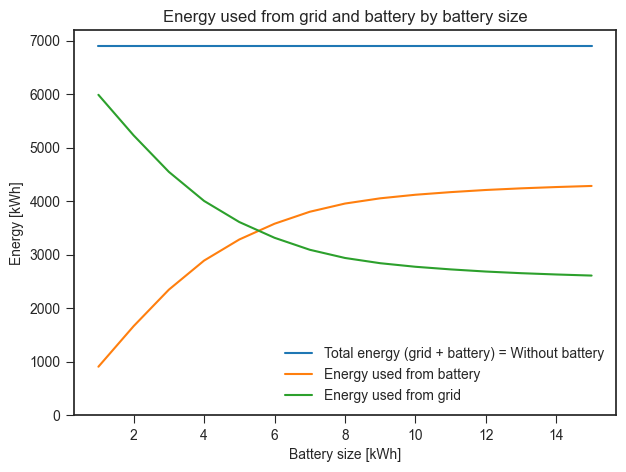

In [88]:
# Plot energy used from grid and from battery for different battery sizes
plt.style.use('seaborn-ticks') #'seaborn-ticks'
plt.figure(figsize=(7,5))
plt.plot(battery_sizes,total_energy, label = 'Total energy (grid + battery) = Without battery')
plt.plot(battery_sizes,bat_energy, label = 'Energy used from battery')
plt.plot(battery_sizes,grid_energy, label = 'Energy used from grid')

plt.ylim(ymin=0) 
plt.legend()
plt.xlabel("Battery size [kWh]")
plt.ylabel("Energy [kWh]")
plt.title("Energy used from grid and battery by battery size")
plt.show()

## Total Energy used from Battery

In [89]:
# Create list that contains column names of batteries
columns =[]
for bat in battery_names:
    columns.append('total_energy_provided_by_battery_' + bat)#
    
print("Total energy used from battery instead of grid (in kWh):")
# Last line in df contains the total energy (in kWh) that was used from the battery
df.iloc[-1][columns]

Total energy used from battery instead of grid (in kWh):


total_energy_provided_by_battery_1      906.957512
total_energy_provided_by_battery_2     1665.501538
total_energy_provided_by_battery_3     2347.114138
total_energy_provided_by_battery_4       2890.6791
total_energy_provided_by_battery_5        3285.063
total_energy_provided_by_battery_6       3579.4382
total_energy_provided_by_battery_7     3803.201175
total_energy_provided_by_battery_8     3956.587525
total_energy_provided_by_battery_9     4054.425713
total_energy_provided_by_battery_10    4121.151413
total_energy_provided_by_battery_11    4170.104738
total_energy_provided_by_battery_12     4210.33375
total_energy_provided_by_battery_13    4240.884488
total_energy_provided_by_battery_14      4265.1832
total_energy_provided_by_battery_15    4285.426038
Name: 85714, dtype: object

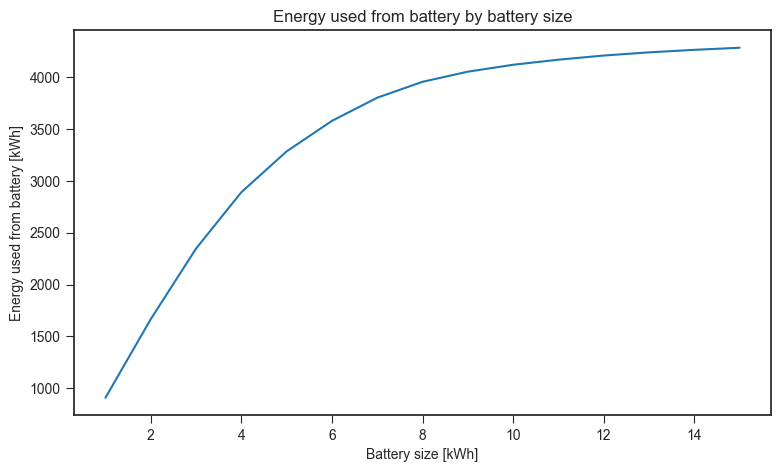

In [90]:
plt.figure(figsize=(9,5))
plt.plot(battery_sizes, df.iloc[-1][columns].tolist(), label = "total_energy_provided_by_battery_" + bat)
plt.xlabel("Battery size [kWh]")
plt.ylabel("Energy used from battery [kWh]")
plt.title("Energy used from battery by battery size")
plt.show()

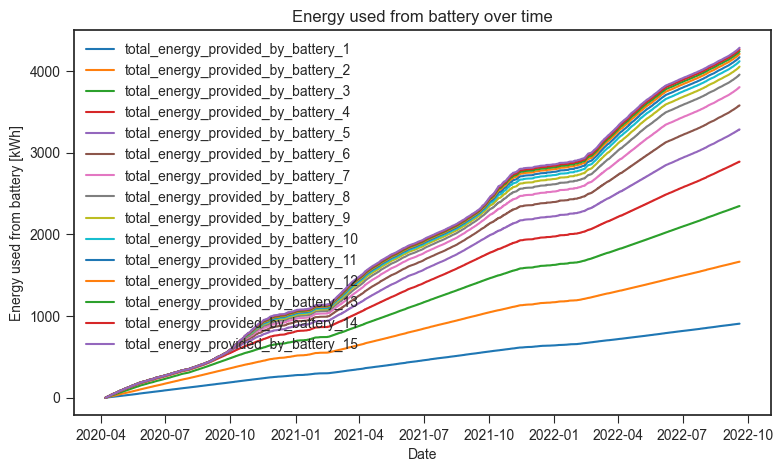

In [91]:
# Plot total energy used by each battery over time
plt.figure(figsize=(9,5))
for bat in battery_names:
    plt.plot(df['time'],df['total_energy_provided_by_battery_' + bat], label = "total_energy_provided_by_battery_" + bat)
plt.legend()
plt.xlabel("Date")
plt.ylabel("Energy used from battery [kWh]")
plt.title("Energy used from battery over time")
plt.show()


## Plot State of Charge for Batteries

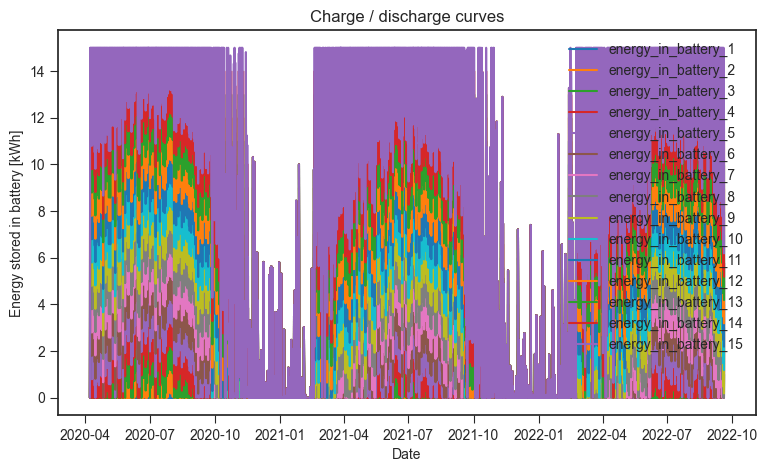

In [92]:
plt.figure(figsize=(9,5))
for i in range(len(battery_names)):
    Ladestatus = df['energy_in_battery_' + battery_names[i]] # / Batterie_Groessen[i] * 100
    plt.plot(df['time'], Ladestatus, label = 'energy_in_battery_' + battery_names[i])
plt.legend()
plt.xlabel("Date")
plt.title("Charge / discharge curves")
plt.ylabel("Energy stored in battery [kWh]")
plt.show()

## Monthly Details

,energy_provided_by_battery_1,energy_provided_by_battery_2,energy_provided_by_battery_3,energy_provided_by_battery_4,energy_provided_by_battery_5,energy_provided_by_battery_6,energy_provided_by_battery_7,energy_provided_by_battery_8,energy_provided_by_battery_9,energy_provided_by_battery_10,energy_provided_by_battery_11,energy_provided_by_battery_12,energy_provided_by_battery_13,energy_provided_by_battery_14,energy_provided_by_battery_15
label,,,,,,,,,,,,,,,
2020-01,7.357675,14.453150,19.969075,22.665863,24.665862,26.665862,28.464137,28.464137,28.464138,28.464138,28.464138,28.464138,28.464138,28.464137,28.464138
2020-02,7.899525,14.958775,20.554175,25.276275,28.310212,29.958250,30.087612,31.087612,31.098962,31.098963,31.098962,31.098962,31.098962,31.098962,31.098962
2020-03,9.136212,17.059462,21.307863,24.896963,26.368113,27.623700,29.623700,31.623700,32.706125,32.706125,32.706125,32.706125,32.706125,32.706125,32.706125
2020-04,25.826262,50.050088,72.415825,89.951575,97.474875,100.389225,102.727150,103.860700,104.516150,104.516150,104.516150,104.516150,104.516150,104.516150,104.516150
2020-05,29.559175,54.882287,75.129213,83.964050,89.768000,93.016950,94.780475,95.780475,96.062575,96.062575,96.062575,96.062575,96.062575,96.062575,96.062575
2020-06,27.780175,52.262300,62.852013,68.599838,70.828588,72.234750,74.234750,76.234750,77.545825,78.545825,79.545825,80.545825,81.244475,81.244475,81.244475
2020-07,29.886813,53.267187,63.069563,66.010538,67.241537,69.067412,70.067412,71.067412,72.067413,72.075788,72.075788,72.075788,72.377138,73.377138,74.377137
2020-08,31.442213,61.573900,85.921487,95.077075,98.847950,101.668363,103.668363,105.444350,106.444350,107.444350,108.444350,108.865962,108.865962,108.865962,108.865962
2020-09,27.199725,52.534137,76.909837,95.497937,106.842862,112.928550,115.991925,118.386250,120.386250,122.386250,124.098687,125.677075,126.825675,127.825675,128.825675


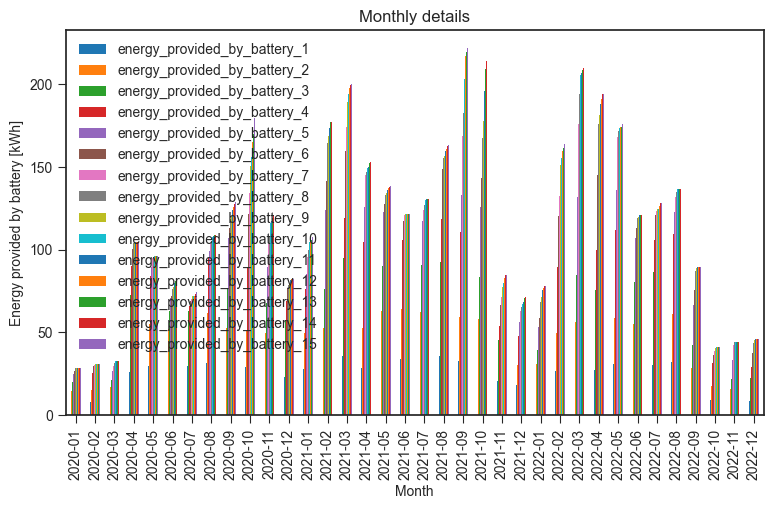

In [93]:
# Used timestamp as index and group results by month
df.index = pd.to_datetime(df['timestamp'])
Monatswerte = df.groupby(pd.Grouper(freq='M')).sum()

# Copy index to new column. Is used afterwards, to create a label of format YYYY-MM
Monatswerte['time'] = Monatswerte.index
Monatswerte['label'] = pd.to_datetime(Monatswerte['time']).dt.to_period('M')
Monatswerte = Monatswerte.set_index('label')

# Show table containing monthly values
columns =[]
for bat in battery_names:
    columns.append('energy_provided_by_battery_' + bat)#


# Plot monthly values as bar chart
ax = Monatswerte[columns].plot.bar(figsize=(9,5), title='Monthly details')
ax.set_xlabel("Month")
ax.set_ylabel("Energy provided by battery [kWh]")
Monatswerte[columns]



# ToDo:
- check length of time period used to calculate energy. If the sensor was removed, data is missing. This results in a long time period between two measurements. As the energy is calculated by multipling the power with the time period, this can result in a huge step.

- Increase performence by improving simulate_battery(). Try to use vectorization instead of the for loop.

- Allow different values of `max_discharging_power` and `max_charging_power` for each battery.

- Consider separate losses during charge and discharge, efficiency is very general.
